## Land Surface Temperature

### Loading Packages

In [1]:
import os
import numpy as np
import pdb
from osgeo import gdal
from osgeo import osr
import matplotlib
from matplotlib import pyplot as plt

### Functions to calculate LST

In [2]:
def BrightnessTemp(B,ADD_BAND,MULT_BAND,k1,k2):
   # Reference: https://www.usgs.gov/core-science-systems/nli/landsat/using-usgs-landsat-level-1-data-product
   vRad = (MULT_BAND * B) + ADD_BAND
   vTemp = ((k2 / np.log((k1/vRad + 1)) - 272.15))
   return vTemp


def LSE(NDVI):
   vEm = np.zeros(NDVI.shape)

   i,j = np.where(NDVI < 0.2)
   vEm[i, j] = 0.97
   
   k, l = np.where(NDVI > 0.5)
   vEm[k, l] = 0.99
   m,n = np.where((NDVI >= 0.2) & (NDVI <= 0.5))
   vEm[m, n] = (0.004*(((NDVI[m, n] - 0.2)/(0.5 - 0.2))**2)) + 0.986

   return vEm

def mono_LST(B_TEMP,B_LSE):
   # old way to compute LST
   #B_LST = (B_TEMP / 1) + (B10 * (B_TEMP/14380) * (np.log(B_LSE)))
   ## BETTER way to computer the LST.
   B_LST = B_TEMP / (1 + (((0.0000115 * B_TEMP) / 14380) * np.log(B_LSE)))
   return B_LST

### Loading tiff files of different bands

In [3]:
vfile = "2020.04.23/"

B4 = vfile+"B4.TIF"
B5 = vfile+"B5.TIF"
B10 = vfile+"B10.TIF"
B11 = vfile+"B11.TIF"
B2 = vfile+"B2.TIF"
B3 = vfile+"B3.TIF"
## For calculating LST.
B4 = gdal.Open(B4)
B4 = B4.ReadAsArray()
B5 = gdal.Open(B5)
B5 = B5.ReadAsArray()
B10 = gdal.Open(B10)
B10 = B10.ReadAsArray()
B11 = gdal.Open(B11)
B11 = B11.ReadAsArray()

## for RGB image
B2 = gdal.Open(B2)
B2 = B2.ReadAsArray()
B3 = gdal.Open(B3)
B3 = B3.ReadAsArray()


### Extract parameter/constants using metadata file

In [5]:
metadata = vfile+ "LC08_L1TP_193026_20200423_20200822_02_T1_MTL.txt"

vRequired = ['SUN_ELEVATION','REFLECTANCE_ADD_BAND_4','REFLECTANCE_MULT_BAND_4',
             'REFLECTANCE_ADD_BAND_5', 'REFLECTANCE_MULT_BAND_5','RADIANCE_ADD_BAND_10',
             'RADIANCE_MULT_BAND_10','RADIANCE_ADD_BAND_11','RADIANCE_MULT_BAND_11',
             'K2_CONSTANT_BAND_11','K2_CONSTANT_BAND_10','K1_CONSTANT_BAND_11','K1_CONSTANT_BAND_10',
             'CORNER_UL_LAT_PRODUCT','CORNER_UR_LAT_PRODUCT','CORNER_UL_LON_PRODUCT','CORNER_UR_LON_PRODUCT',
             'CORNER_LR_LON_PRODUCT','CORNER_LR_LAT_PRODUCT','CORNER_LL_LON_PRODUCT','CORNER_LL_LAT_PRODUCT']
vparams = {}

In [6]:
with open(metadata, 'r') as list_file:
   for x in list_file:
      for y in vRequired:
         if y in x:
            temp = x.rstrip('\n').strip().split('=')[1].strip()
            vparams[y] = float(temp)
         
            
SUN_ELEVATION = vparams['SUN_ELEVATION']
RADIANCE_MULT_BAND_10 = vparams['RADIANCE_MULT_BAND_10']
RADIANCE_MULT_BAND_11 = vparams['RADIANCE_MULT_BAND_11']
RADIANCE_ADD_BAND_10 = vparams['RADIANCE_ADD_BAND_10']
RADIANCE_ADD_BAND_11 = vparams['RADIANCE_ADD_BAND_11']
REFLECTANCE_MULT_BAND_4 = vparams['REFLECTANCE_MULT_BAND_4']
REFLECTANCE_MULT_BAND_5 = vparams['REFLECTANCE_MULT_BAND_5']
REFLECTANCE_ADD_BAND_4 = vparams['REFLECTANCE_ADD_BAND_5']
REFLECTANCE_ADD_BAND_5 = vparams['REFLECTANCE_ADD_BAND_5']
K1_CONSTANT_BAND_10 = vparams['K1_CONSTANT_BAND_10']
K2_CONSTANT_BAND_10 = vparams['K2_CONSTANT_BAND_10']
K1_CONSTANT_BAND_11 = vparams['K1_CONSTANT_BAND_11']
K2_CONSTANT_BAND_11 = vparams['K2_CONSTANT_BAND_11']




CORNER_UL_LAT_PRODUCT = vparams['CORNER_UL_LAT_PRODUCT']
CORNER_UL_LON_PRODUCT = vparams['CORNER_UL_LON_PRODUCT']
CORNER_UR_LAT_PRODUCT = vparams['CORNER_UR_LAT_PRODUCT']
CORNER_UR_LON_PRODUCT = vparams['CORNER_UR_LON_PRODUCT']
CORNER_LL_LAT_PRODUCT = vparams['CORNER_LL_LAT_PRODUCT']
CORNER_LL_LON_PRODUCT = vparams['CORNER_LL_LON_PRODUCT']
CORNER_LR_LAT_PRODUCT = vparams['CORNER_LR_LAT_PRODUCT']
CORNER_LR_LON_PRODUCT = vparams['CORNER_LR_LON_PRODUCT']


In [8]:
#Correct Sun Elevation
sin_sun_elev = np.sin(np.deg2rad(SUN_ELEVATION))
corrected_sun_elev = float(sin_sun_elev)

#Calculate Red Band and NIR band, corrected with sun elevation. Create NDVI based off of these rasters
RED_REF = ((REFLECTANCE_MULT_BAND_4 * B4) - REFLECTANCE_ADD_BAND_4) / (corrected_sun_elev)
NIR_REF = ((REFLECTANCE_MULT_BAND_5 * B5) - REFLECTANCE_ADD_BAND_5) / (corrected_sun_elev)
#opdb.set_trace()

NDVI_REF = (NIR_REF - RED_REF) / (NIR_REF + RED_REF)
#Create variables for the NDVI's max and min values:
NDVI_min = np.min(NDVI_REF)

NDVI_max = np.max(NDVI_REF)


### Working on the area of interest.
Need to fix doesn't work properly right now

In [9]:
vStrt_x = CORNER_LL_LON_PRODUCT
vStrt_y = CORNER_LR_LAT_PRODUCT

vEnd_x = CORNER_UR_LON_PRODUCT
vEnd_y = CORNER_UL_LAT_PRODUCT

vX, vY = B4.shape[0]/(vEnd_x-vStrt_x),B4.shape[1]/(vEnd_y-vStrt_y)

## coordinates of allianz arena
vSearch = [11.6251, 48.2183]
vCoord = [round(vX*(vSearch[0]-vStrt_x)),round(vY*(vSearch[1]-vStrt_y))]
## updating coordinates using offset value.
vCoord = [vCoord[0]+100,vCoord[1]-200]
vbound = 100
vX_s,vX_e = vCoord[0]-vbound,vCoord[0]+vbound
vY_s,vY_e = vCoord[1]-vbound,vCoord[1]+vbound



### Now Calculating LST using band 10,11,4

In [10]:
band10_temp = BrightnessTemp(B10,RADIANCE_ADD_BAND_10,RADIANCE_MULT_BAND_10,
                             K1_CONSTANT_BAND_10,K2_CONSTANT_BAND_10)

band11_temp = BrightnessTemp(B11,RADIANCE_ADD_BAND_11,RADIANCE_MULT_BAND_11,
                             K1_CONSTANT_BAND_11,K2_CONSTANT_BAND_11)

vLSE = LSE(NDVI_REF)
vLST = mono_LST(band10_temp,vLSE)

LST_masked = vLST[vX_s:vX_e,vY_s:vY_e]


### Generating Image of a patch alongside original image 

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]

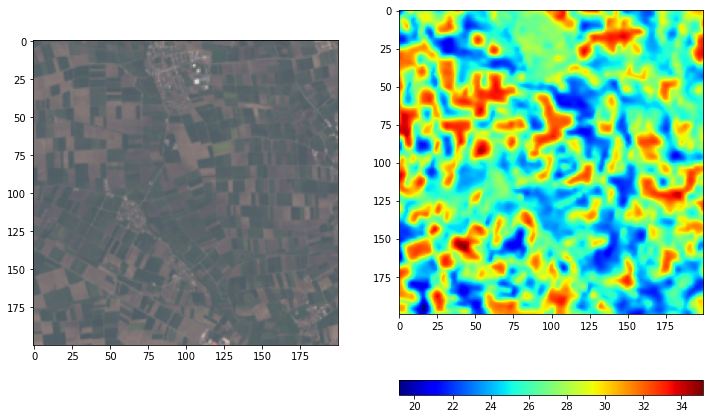

In [13]:
vR = B4[vX_s:vX_e,vY_s:vY_e]
vG = B3[vX_s:vX_e,vY_s:vY_e]
vB = B2[vX_s:vX_e,vY_s:vY_e]
vImg = np.dstack([vR,vG,vB])
vImg = (vImg * (255 / np.max(vImg))).astype(np.uint8)
f, (ax1,ax2) = plt.subplots(1,2)
im = ax2.imshow(LST_masked,cmap=plt.cm.jet)
f.colorbar(im,orientation="horizontal",fraction=0.07)
ax1.imshow(vImg)
plt.show()

### REFERENCES:

1.)https://www.gis-blog.com/calculation-of-land-surface-temperature-lst-from-landsat-8-using-r/#comments

2.) https://github.com/dimejimudele/Land_surface_temperature_Landsat
